# End-to-end pipeline

This notebook contains the first way we made clusters for parking detections and how we used this model to predict new data in a Gradio application

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns

# For visualisations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For UML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Load the data
df_1 = pd.read_csv('/workspaces/MLOps_Project/data/EL1.csv') # The path to the dataset should probably be changed when we're setting up the serverless-ml-pipeline
df_2 = pd.read_csv('/workspaces/MLOps_Project/data/EL2.csv') # The path to the dataset should probably be changed when we're setting up the serverless-ml-pipeline
df_3 = pd.read_csv('/workspaces/MLOps_Project/data/EL3.csv') # The path to the dataset should probably be changed when we're setting up the serverless-ml-pipeline


In [3]:
print(df_1.shape, df_2.shape, df_3.shape)

(8224, 19) (6314, 19) (6032, 19)


In [4]:
df_main = pd.concat([df_1, df_2, df_3], axis=0)

In [5]:
df_main.shape

(20570, 19)

In [6]:
df_main.sample(10)

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,package_type,f_cnt,dr,snr,rssi
2763,2024-03-07 21:57:21.526,3.10,-1.50,839,-675,-781,6,5,5,5,6,6,5,5,PackageType.HEART_BEAT,1787,5,9.8,-93
1931,2024-03-03 16:43:18.280,3.04,8.62,507,-80,-1507,73,50,27,27,21,17,15,13,PackageType.HEART_BEAT,1328,5,8.5,-105
3139,2024-03-04 17:55:26.261,3.04,4.12,274,-910,-460,7,4,6,6,6,6,6,5,PackageType.CHANGE,3240,5,9.2,-93
5187,2024-03-16 10:35:43.803,3.04,8.25,91,-1079,-399,140,127,11,27,27,11,11,8,PackageType.CHANGE,4820,5,9.8,-103
1868,2024-02-27 19:58:32.442,3.04,5.62,70,-1041,-544,147,129,28,19,17,12,12,6,PackageType.CHANGE,2161,5,7.8,-107
5173,2024-03-16 09:01:40.500,3.04,8.00,116,-1071,-402,152,135,12,23,23,15,15,6,PackageType.CHANGE,4806,5,9.5,-105
4031,2024-03-16 18:17:58.084,3.10,8.00,661,-624,-539,6,5,5,5,5,5,5,5,PackageType.HEART_BEAT,2252,5,8.0,-90
875,2024-02-23 07:28:13.547,3.06,5.00,280,-865,-498,7,8,5,5,7,6,6,5,PackageType.CHANGE,1257,5,9.8,-90
2567,2024-03-08 03:25:33.004,3.04,-2.00,563,-93,-1790,5,5,5,5,6,5,5,5,PackageType.HEART_BEAT,1589,5,9.8,-93
1386,2024-02-28 21:29:17.082,3.04,5.00,471,-119,-1626,8,5,6,6,5,5,5,5,PackageType.HEART_BEAT,1109,5,10.0,-99


In [22]:
#df_main.to_csv('EL123.csv')

In [7]:
# Saving the magnetic field data in a new dataframe 
mag = df_main[["x","y","z"]]

In [8]:
# Normalizing the data
scaler = StandardScaler()
mag_normalized = scaler.fit_transform(mag)

In [9]:
print(mag_normalized)

[[ 0.37453026 -0.49185946  0.81720374]
 [-1.32399896 -0.33735403  0.69667847]
 [-1.7254695  -0.37525159  0.80165209]
 ...
 [ 0.08335382  1.47881359 -1.19673463]
 [ 0.07894205  1.46423761 -1.20062255]
 [ 0.09217735  1.4729832  -1.22006211]]


In [10]:
# Clustering the magnetic field data with 2 clusters using kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(mag_normalized)

# Adding cluster labels to the mag dataframe
mag['mag_cluster'] = kmeans.labels_

# Checking the result
mag.sample(5)

/tmp/ipykernel_10304/3757571814.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag['mag_cluster'] = kmeans.labels_


,x,y,z,mag_cluster
2452,80,-998,-477,0
5304,429,-79,-1448,1
1553,758,-656,-713,0
2104,508,-103,-1699,1
3083,779,-653,-694,0


<BarContainer object of 2 artists>

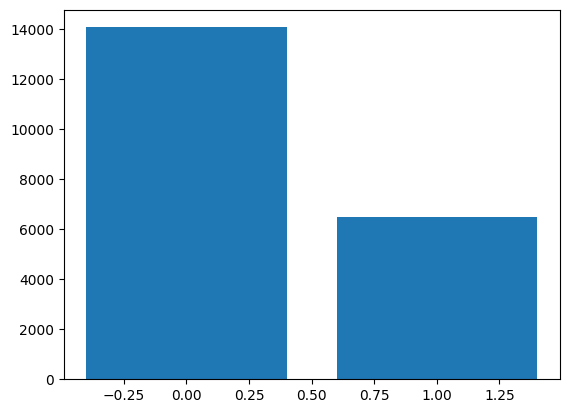

In [11]:
# Checking distribution of different values in mag_cluster values in barplot   
plt.bar(np.arange(2), mag['mag_cluster'].value_counts().values, align='center') # plot histogram for x and y data

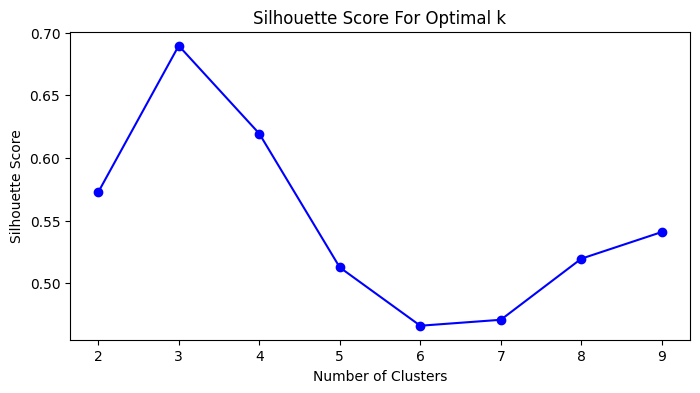

In [12]:
silhouette_avg = []
for k in range(2, 10):  # Starts from 2 clusters 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(mag_normalized, cluster_labels))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_avg, 'bo-')  # Adjust the range as needed
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

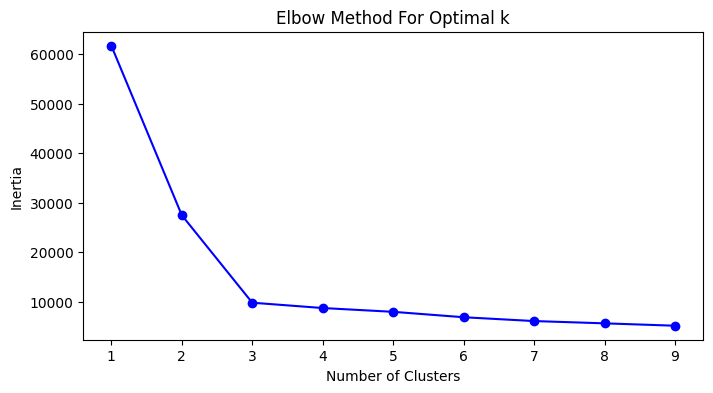

In [13]:
inertia = []
for k in range(1, 10):  
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, 'bo-') 
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

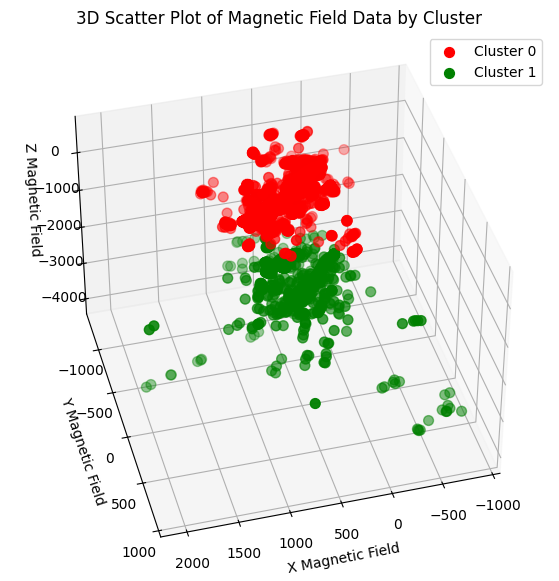

In [14]:
#Visualizing the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# List of colors, ensure you have enough colors for your clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'pink', 'lightblue', 'lightgreen']

# Loop through each cluster 
for i in mag['mag_cluster'].unique():
    # Extract data points belonging to the current cluster
    cluster_data = mag[mag['mag_cluster'] == i]
    ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], s=50, color=colors[i], label=f'Cluster {i}')

ax.set_xlabel('X Magnetic Field')
ax.set_ylabel('Y Magnetic Field')
ax.set_zlabel('Z Magnetic Field')
ax.set_title('3D Scatter Plot of Magnetic Field Data by Cluster')
ax.legend()

# Set the view angle
ax.view_init(elev=40, azim=75
)

plt.show()

In [15]:
df_main['mag_cluster'] = mag['mag_cluster']

In [16]:
df_main.sample(10)

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,package_type,f_cnt,dr,snr,rssi,mag_cluster
1210,2024-02-27 13:49:23.143,3.12,5.75,901,-23,-1044,59,139,128,34,37,14,31,40,PackageType.CHANGE,1022,5,3.8,-112,1
7,2024-02-13 13:30:13.713,3.14,19.12,467,-617,-490,14,6,5,4,4,6,6,5,PackageType.HEART_BEAT,220,0,3.0,-118,0
1494,2024-02-26 14:15:22.745,3.04,8.88,243,-886,-438,10,5,5,5,5,5,5,5,PackageType.CHANGE,1808,5,8.8,-91,0
159,2024-02-20 09:34:10.728,3.06,9.25,304,-857,-452,7,6,6,5,6,7,6,6,PackageType.CHANGE,609,2,9.8,-89,0
3809,2024-03-15 05:00:13.345,3.12,5.75,700,-642,-590,5,5,5,5,5,8,8,6,PackageType.HEART_BEAT,2172,5,8.8,-94,0
4468,2024-03-12 09:13:52.820,3.02,5.62,249,-870,-450,8,5,5,5,4,4,4,5,PackageType.CHANGE,4237,5,9.8,-103,0
5810,2024-03-28 10:48:49.666,3.10,9.88,489,-907,-725,37,99,100,52,63,17,20,11,PackageType.HEART_BEAT,3014,5,9.5,-97,0
5553,2024-03-26 15:50:08.184,3.10,14.25,561,-604,-355,4,3,3,5,5,4,5,5,PackageType.HEART_BEAT,2920,5,9.8,-89,0
3314,2024-03-11 18:34:43.041,3.10,4.62,809,-531,-570,197,178,176,97,65,64,31,22,PackageType.HEART_BEAT,1989,5,6.2,-106,0
4015,2024-03-09 16:55:32.468,3.04,3.00,280,-896,-474,7,5,6,6,6,6,4,6,PackageType.HEART_BEAT,3891,5,9.8,-91,0


From here on we assume that the clusters are labels for the data and we can use them for further analysis
Cluster 0 is detection and 1 is no detection

In [17]:
detection_df = df_main[df_main['mag_cluster'] == 0]
no_detection_df = df_main[df_main['mag_cluster'] == 1]

In [20]:
detection_df.describe()

,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,f_cnt,dr,snr,rssi,mag_cluster
count,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.0
mean,3.069966,6.957568,411.294498,-782.197114,-480.347313,31.120984,27.375320,15.252061,14.043361,11.749716,9.048692,7.884276,6.410151,3114.496872,4.891740,8.304350,-98.185456,0.0
std,0.036686,4.322847,255.500021,149.631500,199.238626,52.874328,46.355608,28.951282,22.223980,15.659379,9.740573,6.455042,3.927521,1891.356737,0.614747,2.118338,6.923344,0.0
min,3.020000,-2.750000,-374.000000,-1275.000000,-1433.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,213.000000,0.000000,-9.800000,-121.000000,0.0
25%,3.040000,4.500000,230.000000,-874.250000,-588.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1686.000000,5.000000,7.500000,-103.000000,0.0
50%,3.040000,6.380000,293.000000,-819.000000,-487.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,2729.000000,5.000000,9.000000,-96.000000,0.0
75%,3.100000,8.880000,691.000000,-644.000000,-362.750000,9.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,4420.000000,5.000000,9.500000,-93.000000,0.0
max,3.160000,26.000000,1156.000000,401.000000,603.000000,255.000000,255.000000,252.000000,249.000000,129.000000,100.000000,68.000000,45.000000,7386.000000,5.000000,13.500000,-85.000000,0.0


In [21]:
no_detection_df.describe()

,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,f_cnt,dr,snr,rssi,mag_cluster
count,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.000000,6502.0
mean,3.045543,6.692087,458.154260,-102.268225,-1473.840049,20.870194,17.613042,14.459090,11.994617,10.611966,8.213473,7.461858,6.796986,1736.250077,4.884036,8.148216,-101.035989,1.0
std,0.020153,4.393264,140.744999,87.480392,276.160485,37.478966,33.469532,24.987548,18.615999,15.052674,7.685497,6.417870,4.700081,692.021918,0.587068,2.146223,5.005636,0.0
min,3.020000,-2.120000,-860.000000,-897.000000,-4087.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,229.000000,0.000000,-16.800000,-121.000000,1.0
25%,3.040000,4.000000,414.000000,-115.000000,-1633.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1145.250000,5.000000,7.200000,-103.000000,1.0
50%,3.040000,6.120000,453.000000,-89.000000,-1517.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,1725.000000,5.000000,8.800000,-100.000000,1.0
75%,3.040000,8.250000,502.000000,-77.000000,-1359.000000,9.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2356.750000,5.000000,9.500000,-97.000000,1.0
max,3.140000,24.250000,2041.000000,905.000000,-133.000000,255.000000,255.000000,163.000000,140.000000,139.000000,103.000000,104.000000,44.000000,2916.000000,5.000000,13.000000,-76.000000,1.0


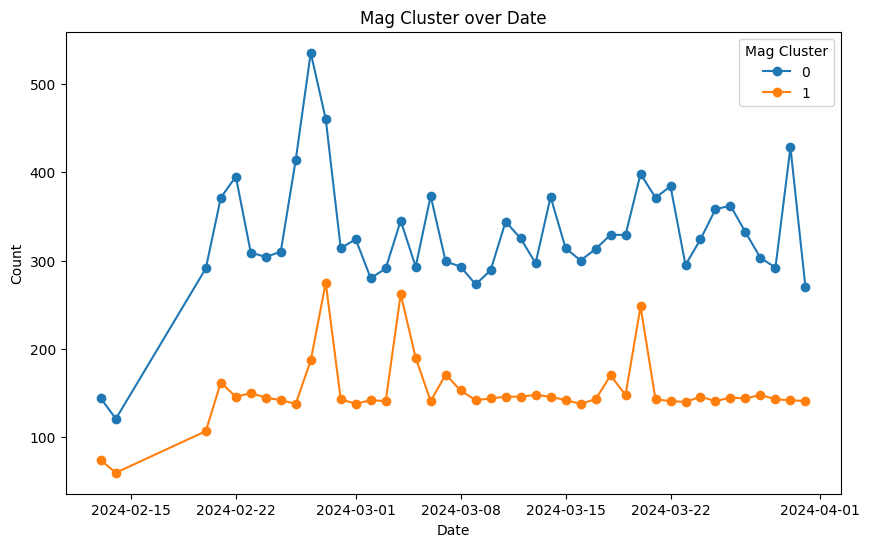

In [22]:
# Convert the 'time' column to datetime
df_main['time'] = pd.to_datetime(df_main['time'])

# Group the data by date and count the occurrences of each mag_cluster
grouped_data = df_main.groupby(df_main['time'].dt.date)['mag_cluster'].value_counts().unstack().fillna(0)

# Plot the line plot
grouped_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Mag Cluster over Date')
plt.legend(title='Mag Cluster')
plt.show()


We need to split our DataFrame into two Dataframes.

The features DataFrame will contain the inputs for training/inference.
The labels DataFrame will contain the target we are trying to predict.

In [23]:
features = df_main[["x", "y", "z"]]
labels = df_main[["mag_cluster"]]
features

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,x,y,z
0,511,-736,-374
1,126,-683,-436
2,35,-696,-382
3,27,-697,-379
4,26,-696,-370
...,...,...,...
6027,441,-65,-1405
6028,444,-62,-1411
6029,445,-60,-1410
6030,444,-65,-1412


We can split our features and labels into a train_set and a test_set. 

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(features, labels, test_size=0.2)
y_train

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,mag_cluster
3324,0
2514,1
2330,0
891,1
3863,1
...,...
6992,0
4554,1
3935,0
5770,1


In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [28]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 1, 0, 1], dtype=int32)

In [29]:
from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'0': {'precision': 0.9989376770538244, 'recall': 0.9996456413890857, 'f1-score': 0.9992915338292596, 'support': 2822.0}, '1': {'precision': 0.9992248062015504, 'recall': 0.9976780185758514, 'f1-score': 0.9984508133230054, 'support': 1292.0}, 'accuracy': 0.9990277102576568, 'macro avg': {'precision': 0.9990812416276874, 'recall': 0.9986618299824686, 'f1-score': 0.9988711735761325, 'support': 4114.0}, 'weighted avg': {'precision': 0.9990278498440193, 'recall': 0.9990277102576568, 'f1-score': 0.9990275059016758, 'support': 4114.0}}


In [30]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)
print(results)

[[2821    1]
 [   3 1289]]


<Axes: >

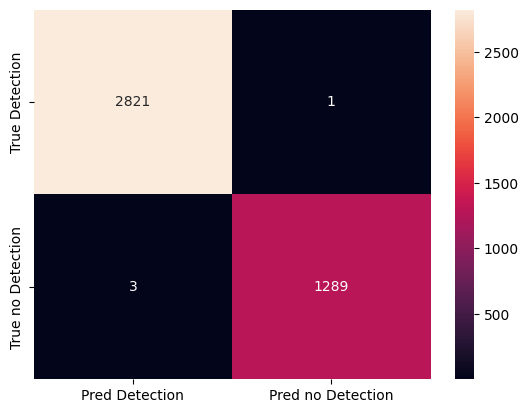

In [36]:
df_cm = pd.DataFrame(results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

sns.heatmap(df_cm, annot=True, fmt='g')

In [37]:
!pip install gradio --quiet
!pip install typing-extensions==4.3.0

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.2 requires typing-extensions>=4.8.0, but you have typing-extensions 4.3.0 which is incompatible.
fastapi 0.110.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.3.0 which is incompatible.
pydantic 2.7.0 requires typing-extensions>=4.6.1, but you have typing-extensions 4.3.0 which is incompatible.
pydantic-core 2.18.1 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.3.0 which is incompatible.


In [38]:
import gradio as gr

/home/codespace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
def detec(x, y, z):
    input_list = [x, y, z]
    res = model.predict(np.asarray(input_list).reshape(1, -1))
    prediction = res[0]
    # Convert numerical prediction to string label
    if prediction == 1:
        label = "No Detection"
    else:
        label = "Detection"
    return label

demo = gr.Interface(
    fn=detec,
    title="Detection or No Detection Predictive Analytics",
    description="Experiment with x, y, and z values to predict if there's a detection or not.",
    allow_flagging="never",
    inputs=[
        gr.Number(value=1.0, label="X value"),
        gr.Number(value=1.0, label="Y value"),
        gr.Number(value=1.0, label="Z value"),
    ],
    outputs=gr.Label()
)

demo.launch(share=True)


Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://2376b32dd8898b46ff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
